# 투빅스 15기 정규세션 10주차 DCGAN 구현 과제
"빈칸" 부분을 채우는 과제입니다. "빈칸"뿐만 아니라 중간중간 주석 또는 마크다운으로 설명 부탁드립니다  
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py  
위의 주소는 pytorch dcgan 공식 튜토리얼 코드로 해당 코드를 바탕으로 과제를 만들었습니다. 튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋을 것 같습니다  
다만, 그대로 복붙이 아닌 코드를 이해해 나가면서 과제를 수행해주시기 바랍니다  
마지막 과제인 만큼 다들 화이팅!

## 드라이브 연결 (코랩 기본 저장소를 사용하여 사용하지 않았습니다.)

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
# import os
# os.chdir('/content/gdrive/My Drive/')

## 패키지 임포트

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [4]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= True,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), #이미지 64x64로 크기 변환
                                                     transforms.ToTensor(), #텐서자료형으로 변환
                                                     transforms.Normalize((0.5,), (0.5,)), #노말라이즈를 통해 -1.~1.의 값을 갖게 변환
                     ]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 데이터 확인하기

In [5]:
print('number of training data: ', len(dataset)) #데이터 수 확인
image,_ = dataset[0]
print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


MNIST 데이터가 총 60000개이며 64*64 사이즈로 올바르게 변환된 것을 확인할 수 있었습니다.

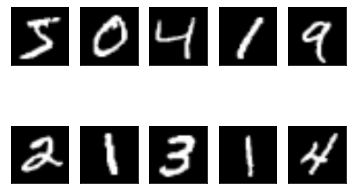

In [6]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i] # 이미지 배열만 가져온다.
    image = (image+1)/2 # 이미지 정규화 풀기.. (안하고 실행해도 무방했습니다.)
    image = image.squeeze() # 차원 축소 (채널 제거하고 2차원 행렬로 변환)
    np_img = image.numpy() # 넘파이 배열로 변환
    
    subplot = fig.add_subplot(2, 5, i+1) # 2행 5열로 이미지를 그린다.
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [7]:
# dataloader
batch_size = 128 # 논문에서 128개의 배치 사이즈로 학습했으므로 그대도 진행합니다.
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

## device 정의

In [8]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU가 사용 가능하면 사용 설정
print(device)

cuda:0


## 신경망 

In [9]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training images => MNIST 데이터에서는 흑백 이미지이므로 1입니다.
nz = 100 # size of z latent vector => 논문에 나온 그대로 진행했습니다. 
ngf = 64 # size of feature maps in generator => 논문에서는 128로 진행한 것 같은데 문제에 64로 나와 있으니 그대로 두겠습니다!
ndf = 64 # size of feature maps in discriminator 


### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: # Conv 레이어이면..
        nn.init.normal_(m.weight.data, 0.0, 0.02) # 논문대로 모든 가중치는 정규분포 (0, 0.02로 초기화합니다.)
    elif classname.find('BatchNorm') != -1: # BatchNorm레이어이면..
        nn.init.normal_(m.weight.data, 1.0, 0.02) # BatchNorm에 대한 초기화는 논문에는 나와있지 않았습니다. 파이토치 홈페이지를 참고했습니다.
        nn.init.constant_(m.bias.data, 0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels= nz, out_channels=8*ngf, kernel_size=4, stride=1, padding=0, bias=False), # 논문에 나온 조건으로 레이어를 생성합니다. (Z를 업샘플링하여 다차원 벡터로 만드는 과정입니다.)
            nn.BatchNorm2d(num_features = 8*ngf), # 세 개 레이어를 제외한 모든 레이어에 BatchNorm이 적용되었다고 논문에 적혀있습니다.
            nn.ReLU(inplace = True), # 활성화 함수로 ReLU를 사용합니다.
            # => 8*ngf * 4 * 4 의 텐서

            nn.ConvTranspose2d(in_channels= 8*ngf, out_channels=4*ngf, kernel_size=4, stride=2, padding=1, bias=False), # 논문에 나온 조건으로 레이어를 생성합니다.
            # 논문 문서의 그림에서는 kernel_size를 5로 놓고 쓰지만(?), 문제의 출처에서 사용한 Celeb-A 데이터셋이 오히려 MNIST와 비슷하다고 생각해 토치 사이트의 자료를 참고하였습니다.
            nn.BatchNorm2d(num_features = 4*ngf), # 두 개 레이어를 제외한 모든 레이어에 BatchNorm이 적용되었다고 논문에 적혀있습니다.
            nn.ReLU(inplace = True), # 활성화 함수로 ReLU를 사용합니다.
            # => 4*ngf * 8 * 8 의 텐서

            nn.ConvTranspose2d(in_channels= 4*ngf, out_channels=2*ngf, kernel_size=4, stride=2, padding=1, bias=False), # 논문에 나온 조건으로 레이어를 생성합니다.
            # 마찬가지로 논문 문서의 그림에서는 kernel_size를 5로 놓고 사용하는 것 같습니다
            nn.BatchNorm2d(num_features = 2*ngf), # 두 개 레이어를 제외한 모든 레이어에 BatchNorm이 적용되었다고 논문에 적혀있습니다.
            nn.ReLU(inplace = True), # 활성화 함수로 ReLU를 사용합니다.
            # => 2*ngf * 16 * 16 의 텐서

            nn.ConvTranspose2d(in_channels= 2*ngf, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False), # 논문에 나온 조건으로 레이어를 생성합니다.
            # 마찬가지로 논문 문서의 그림에서는 kernel_size를 5로 놓고 사용하는 것 같습니다
            nn.BatchNorm2d(num_features = ngf), # 두 개 레이어를 제외한 모든 레이어에 BatchNorm이 적용되었다고 논문에 적혀있습니다.
            nn.ReLU(inplace = True), # 활성화 함수로 ReLU를 사용합니다.
            # => ngf * 32 * 32 의 텐서

            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False ),
            nn.Tanh() # 마지막 계층은 BatchNorm을 적용하지 않습니다.
            # => nc * 64 * 64 의 텐서
        )

    def forward(self, input):
        return self.main(input) # 만들어 놓은 Sequential에 input데이터를 넣어서 계산합니다.


논문의 생성자는 다음 그림과 같이 묘사가 되어 있습니다.

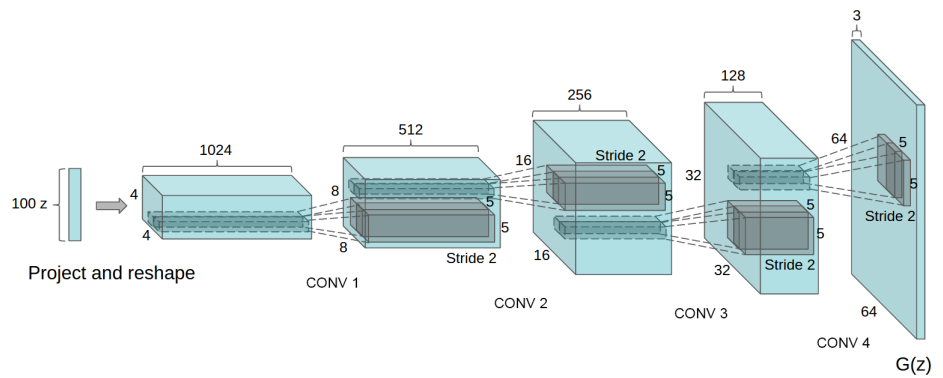

그림을 참고해 보면, 첫 번째 레이어의 커널 크기는 1이고, 2번째 레이어부터 커널 크기가 5가 아닐까? 하는 생각이 들었습니다.

간단한 계산을 통해 이를 해결해 보고자 했습니다.

Transpose2d의 output shape를 구하는 공식은 다음과 같습니다.


> H_out ​= (H_in​−1)×stride[0] − 2×padding[0] + dilation[0]×(kernel_size[0]−1) + output_padding[0] + 1

> W_out​ = (W_in​−1)×stride[1] − 2×padding[1] + dilation[1]×(kernel_size[1]−1) + output_padding[1] + 1

따라서 두 번째 Conv층의 output 을 계산하면 다음과 같을 것입니다.
> (4-1) * 2 - 2 * 1 + 1 * (4-1) + 1 == 8

논문의 방식대로 계산했다면 다음과 같습니다.
> (4-1) * 2  - 2 * (padding_size) + 1 * (5-1) + 1 == .. 이를 만족하는 padding size가 존재하지 않습니다.

따라서 논문의 그림에 오타가 있었던 것으로 생각이 됩니다.
.. 

In [12]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 판별자 클래스

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__() # 판별자는 생성자가 거친 과정을 역순으로 거칩니다.
        self.main = nn.Sequential(
            nn.Conv2d(in_channels= nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False), # Generator의 역순으로 레이어를 쌓습니다. ConvTransepose2d가 Conv2d로 바뀌었습니다.
            # Discriminator의 첫 계층은 BatchNorm을 적용하지 않는다고 적혀있었습니다.
            nn.LeakyReLU(negative_slope=0.2, inplace = True), # 활성화 함수로 LeakyReLU(0.2)를 사용합니다.
            # => ndf * 32 * 32 의 텐서

            nn.Conv2d(in_channels= ndf, out_channels=ndf * 2, kernel_size=4, stride=2, padding=1, bias=False), # Generator의 역순으로 레이어를 쌓습니다.
            nn.BatchNorm2d(num_features = ndf * 2), # 이 계층부터 BatchNorm이 적용되기 시작합니다.
            nn.LeakyReLU(negative_slope=0.2, inplace = True), # 활성화 함수로 LeakyReLU(0.2)를 사용합니다.
            # => 2*ndf * 16 * 16 의 텐서

            nn.Conv2d(in_channels= ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, padding=1, bias=False), # Generator의 역순으로 레이어를 쌓습니다.
            nn.BatchNorm2d(num_features = ndf * 4), # 이 계층부터 BatchNorm이 적용되기 시작합니다.
            nn.LeakyReLU(negative_slope=0.2, inplace = True), # 활성화 함수로 LeakyReLU(0.2)를 사용합니다.
            # => 4*ndf * 8 * 8 의 텐서

            nn.Conv2d(in_channels= ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1, bias=False), # Generator의 역순으로 레이어를 쌓습니다.
            nn.BatchNorm2d(num_features = ndf * 8), # 이 계층부터 BatchNorm이 적용되기 시작합니다.
            nn.LeakyReLU(negative_slope=0.2, inplace = True), # 활성화 함수로 LeakyReLU(0.2)를 사용합니다.
            # => 8*ndf * 4 * 4 의 텐서

            nn.Conv2d(in_channels= ndf * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False), # Generator의 역순으로 레이어를 쌓습니다.
            # output계층은 BatchNorm이 적용되지 않습니다.
            nn.Sigmoid() # 활성화 함수로 sigmoid를 사용해 예측 점수(생성자가 생성한 이미지인 점수)를 반환합니다.

        )

    def forward(self, input):
        return self.main(input)

In [14]:
netD = Discriminator().to(device) # 생성자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Function & Optimizer

DCGAN에서 사용한 손실함수는 `BCELoss(Binary Cross Entropy Loss` 입니다.

주어진 데이터가 진짜 데이터이면 1, 가짜 데이터이면 0이라고 할 때,

진짜 데이터의 log함수값은 최대화시키고, 가짜 데이터의 log함수값은 최소화 시킬 수 있게 디자인되어 있습니다.

$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]$


In [ ]:
# 손실함수
criterion = nn.BCELoss() # 위에서 설명한 함수가 구현되어 있습니다.

real_label = 1. # 진짜 데이터인 경우에 1
fake_label = 0.

# optimizer hyperparameters
learning_rate = 0.0002 # 논문에서 사용한 수치입니다.
beta1 = 0.5 # 마찬가지로 논문에서 학습 안정화를 위해 사용되었습니다.

# optimizers
optimizerD = optim.Adam(params=netD.parameters(), lr = learning_rate, betas=(beta1, 0.999)) # 논문에서 제시한 파라미터를 그대로 사용합니다.
optimizerG = optim.Adam(params=netG.parameters(), lr = learning_rate, betas=(beta1, 0.999)) # 다른 모델의 가중치와 step에 영향을 받지 않도록 optimizer를 따로 설정해야 합니다.

## Train
"빈칸"을 채우고, 각각의 변수 및 메소드가 무엇을 나태는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

In [16]:
num_epochs = 5

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # 먼저 Discriminator의 학습을 진행합니다. => 학습된 판별자가 판별한 정답에 대해서 생성자 학습이 진행되기 때문입니다.
        # Discriminator의 목적은 손실함수를 maximize하는 것입니다.

        netD.zero_grad() # 기울기 초기화
        real_cpu = data[0].to(device) # 데이터를 GPU에 올립니다.(변수명은 따로 수정하지 않았습니다.) data[0]을 쓰는 이유는 data가 픽셀값과 label로 이루어져 있는데, label을 쓰지 않기 때문입니다.
        b_size = real_cpu.size(0) # 배치 사이즈를 구합니다.
        label = torch.full((b_size, ), real_label, dtype=torch.float, device=device) # b_size만큼 1로 채운 label을 생성합니다. 모든 데이터가 진짜이므로(dataloader에서 나왔으니까) 정답은 1 뿐입니다. 

        output = netD(real_cpu).view(-1) # 모델이 예측하고 결과를 1차원 벡터로 변환합니다.
        errD_real = criterion(output, label) # output을 1로 잘 예측했는지를 확인합니다.
        errD_real.backward() # 역전파를 구합니다.
        D_x = output.mean().item() # 진짜 이미지를 얼마나 잘 구분했는지에 대한 평균값을 구합니다.

        # 이미지 생성을 위한 Z벡터를 생성합니다. randn은 평균0, 분산1인 데이터를 생성합니다.
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        fake = netG(noise) # 생성자가 가짜 이미지를 생성합니다.
        label.fill_(fake_label) # 배치 사이즈만큼 0으로 채워진 label을 만듭니다. (모든 데이터가 가짜 데이터이므로 0이어야 합니다.)
        output = netD(fake.detach()).view(-1) # 판별자가 이번에는 가짜 이미지를 구분합니다.
        # fake(netG의 출력)에 대한 역전파를 막기 위해 detach를 수행합니다.
        errD_fake = criterion(output, label) # 데이터에 대해 0으로 잘 예측했는지 손실을 구합니다.
        errD_fake.backward() # 이번 함수에 대해서도 역전파를 수행합니다. 그래프 기울기가 이전과 누적됩니다.
        D_G_z1 = output.mean().item() # 가짜 이미지를 얼마나 잘 구분했는지에 대한 평균을 구합니다.

        errD = errD_real + errD_fake # 총 손실 합을 구합니다.
        optimizerD.step() # 학습을 실시하여 기울기를 업데이트합니다.


        # 판별자를 학습했으니 생성자를 학습합니다.
        # 생성자는 log(D(G(z)))를 maximize 합니다. (즉 판별자가 1이라고 예측할 확률을 최대화합니다.)

        netG.zero_grad() # 기울기 초기화
        label.fill_(real_label) # 다 진짜로 속입니다. 이를 위해 정답은 1입니다.
        output = netD(fake).view(-1) # 판별자가 가짜 이미지에 대해 판정합니다. 기존에 생성한 이미지에 대해 학습된 모델로 다시 판정합니다.
        errG = criterion(output, label) # 생성자는 판별자가 1이라고 예측할 확률을 최대화하며, 이는 즉 loss function이 최소화되는 것입니다.(구분자 입장에서)
        errG.backward() # 기울기 역전파를 실시합니다.
        D_G_z2 = output.mean().item() # 생성자가 만든 이미지를 얼마나 잘 구분했는지에 대한 평균 점수입니다.

        optimizerG.step() # 기울기 역전파를 시행합니다.

        # 학습 경과 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

[0/5][0/469]	Loss_D: 1.6978	Loss_G: 2.7174	D(x): 0.3921	D(G(z)): 0.3881 / 0.0894
[0/5][50/469]	Loss_D: 0.0409	Loss_G: 8.7956	D(x): 0.9739	D(G(z)): 0.0046 / 0.0002
[0/5][100/469]	Loss_D: 0.2607	Loss_G: 13.9104	D(x): 0.8650	D(G(z)): 0.0000 / 0.0001
[0/5][150/469]	Loss_D: 0.1257	Loss_G: 5.3212	D(x): 0.9528	D(G(z)): 0.0680 / 0.0062
[0/5][200/469]	Loss_D: 1.5471	Loss_G: 0.7105	D(x): 0.3436	D(G(z)): 0.0016 / 0.5512
[0/5][250/469]	Loss_D: 0.9962	Loss_G: 1.7690	D(x): 0.4856	D(G(z)): 0.1027 / 0.2171
[0/5][300/469]	Loss_D: 0.1478	Loss_G: 3.8412	D(x): 0.9390	D(G(z)): 0.0711 / 0.0312
[0/5][350/469]	Loss_D: 0.2528	Loss_G: 3.3486	D(x): 0.8929	D(G(z)): 0.1155 / 0.0495
[0/5][400/469]	Loss_D: 0.5100	Loss_G: 1.3962	D(x): 0.7182	D(G(z)): 0.1124 / 0.2971
[0/5][450/469]	Loss_D: 0.1253	Loss_G: 3.4884	D(x): 0.9232	D(G(z)): 0.0358 / 0.0433
[1/5][0/469]	Loss_D: 0.1226	Loss_G: 3.7493	D(x): 0.9685	D(G(z)): 0.0821 / 0.0357
[1/5][50/469]	Loss_D: 0.3733	Loss_G: 2.6643	D(x): 0.8205	D(G(z)): 0.1372 / 0.0929
[1/5][100

로그에 찍히는 값들의 의미는 다음과 같습니다.
- loss_d : 판별자의 손실값입니다.
- loss_g : 생성자의 손실값입니다. 이 두개는 낮을 수록 좋은 값입니다. 목표로 하는 값과의 차이를 나타내기 때문입니다.

- D(x) : 판별자가 진짜 이미지에 대해 예측한 점수의 평균입니다. 진짜 이미지의 label이 1이기 때문에 1에 가까울수록 좋은 모델입니다.

- D(G(x)) : 판별자가 가짜 이미지에 대해서 예측한 점수의 평균이며, 학습 후 예측한 점수의 평균입니다. 판별자 입장에서 가짜 이미지의 label이 0이기 때문에 0에 가까울수록 좋은 모델입니다.

학습하는 내용으로 볼 때, 모델이 어느정도 진동하는 모습을 보이나, D(x)는 1에 수렴하려는 양상을, D(G(z))는 0에 수렴하려는 양상을 확인할 수 있었습니다. 학습이 잘 되고 있다는 뜻으로 보입니다.

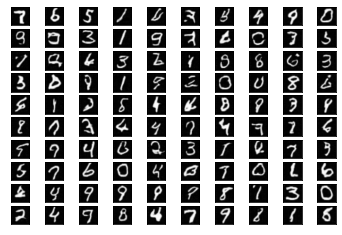

In [30]:
# 생성자가 생성한 이미지를 시각화 해 보았습니다.
fig = plt.figure()

noise = torch.randn(100, nz, 1, 1, device=device)
image = netG(noise)
image = image.cpu().detach().numpy()
image = image.squeeze() # 차원 축소 (채널 제거하고 2차원 행렬로 변환)

for i in range(100): # 100개를 확인해 보겠습니다
    subplot = fig.add_subplot(10, 10, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(image[i], cmap = 'gray')

plt.show()

일부 이미지는 숫자처럼 명확한 이미지를 보이나, 일부 이미지는 숫자처럼 보이지 않는 것을 볼 수 있었습니다.

하지만 전반적으로 MNIST 처럼 보이는 형태로 잘 생성된 것을 확인할 수 있어 모델이 잘 학습된 것을 볼 수 있었습니다.